# Part A Convolution Neural Networks
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
## Background Infomation



## Initializing Libaries

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import keras_tuner as kt
import visualkeras
from keras.regularizers import l1, l2
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential
from keras.models import Model
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping

Using TensorFlow backend


## Checking GPU

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Fixing random seed

In [4]:
seed = 69
np.random.seed(seed)

## factors to consider/research

- overfitting (how to prevent it)
    - data augmentation
    - L1 and L2 regulazation
    - dropout layers
    - 
- how does the various parameter of a model (dense layers, parameters of dense layers, activation fucntions, optimizers, learning rate, weigh initilzation, et...)
- affect it eg its accuracy and how does it learn/ will it have vanishing gradient / exploding gradient or any other problems?
- training time and efficiency
    - batch size
- 

## Problem statement
Our problem for this assignment is to create a deep learning model to predict vegatables using the dataset on vegatables.

We need to create 2 seperate final models to predict images on 2 different input sizes:
- 31 x 31
- 128 x128 

## Goals of this project
### Generalise to data well
> To make sure our model is able to generalise to data well, we need to __minimize__ the difference between our training accuracy and test accuracy.
### Accuracy
> In order to minimize avoidable bias, it is important for the model to achieve a training set accuracy of at least __85%__ or higher, which signifies a reasonable level of accuracy.

# Importing Datasets

In [5]:
directory_train = './datasets/Dataset for CA1 part A/train'
directory_test = './datasets/Dataset for CA1 part A/test'
directory_validation = './datasets/Dataset for CA1 part A/validation'

def dataset(directory,image_size,seed=seed,batch_size=64):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        color_mode='grayscale',
        image_size=image_size,
        shuffle=True,
        seed=seed,
        batch_size=batch_size
    )
    return dataset


In [6]:
dataset_train_31 = dataset(directory_train,(31,31))
dataset_test_31 = dataset(directory_test,(31,31))
dataset_validation_31 = dataset(directory_validation,(31,31))

dataset_train_128 = dataset(directory_train,(128,128))
dataset_test_128 = dataset(directory_test,(128,128))
dataset_validation_128 = dataset(directory_validation,(128,128))

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## EDA
What can we get from our EDA?
- How does the average image look like for each class?
- How is the class distribution?
- How does a sample image look like for each class?


In [7]:
class_labels = [
    "Bean",
    "Bitter Gourd",
    "Bottle Gourd",
    "Brinjal",
    "Broccoli",
    "Cabbage",
    "Capsicum",
    "Carrot",
    "Cauliflower",
    "Cucumber",
    "Papaya",
    "Potato",
    "Pumpkin",
    "Radish",
    "Tomato",
]

In [29]:
for images, labels in dataset_train_31.take(1):
    print("31x31 Batch Shape:", images.shape)
for images, labels in dataset_train_128.take(1):
    print("128x128 Batch Shape:", images.shape)

31x31 Batch Shape: (64, 31, 31, 1)
128x128 Batch Shape: (64, 128, 128, 1)


Our image shapes are 31x31 and 128x128, with a single colour channel.

We have a default batch size of 64, since tf.keras.preprocessing.image_dataset_from_directory requires a default batch size or else the model wont fit properly. Fortunatly we can set our batch size again when we fit our models.

### Visualizing our datasets

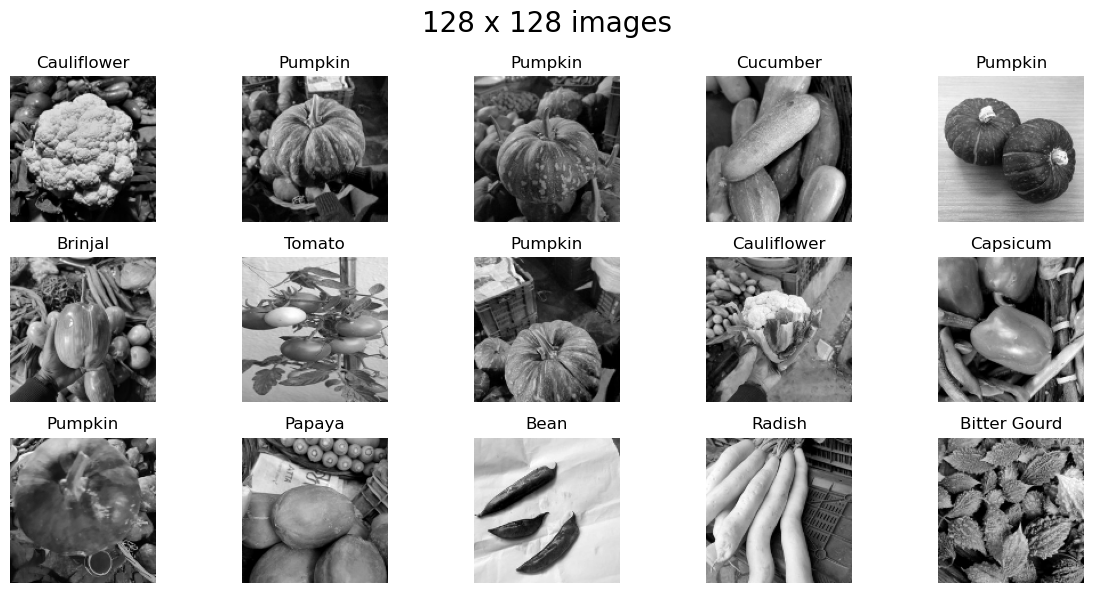

In [31]:
def plot_dataset(amtOfImages, dataset,title,class_labels):

    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=20)

    for images, labels in dataset.take(1):
        num_images = len(images)  

        row = int(np.sqrt(amtOfImages))
        col = int(np.ceil(amtOfImages / row))
        
        for i in range(min(amtOfImages, num_images)):
            ax = plt.subplot(row, col, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
            plt.title(class_labels[np.argmax(labels[i])])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_dataset(15,dataset_train_128,'128 x 128 images',class_labels)

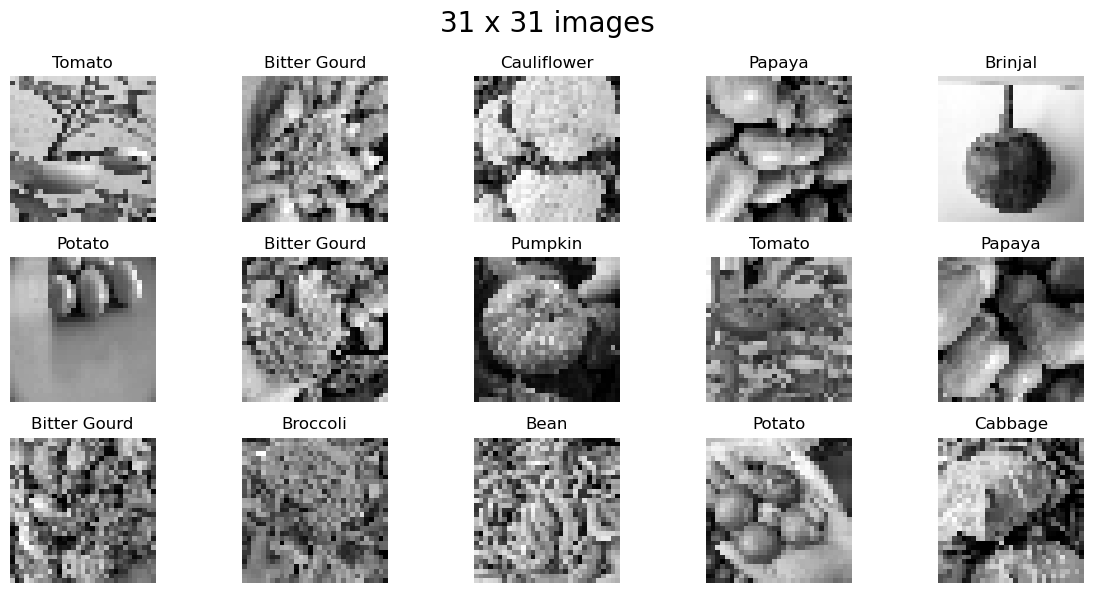

In [32]:
plot_dataset(15,dataset_train_31,'31 x 31 images',class_labels)

Observations:
- We can hardly differentiate between classes for images of size 31x31, hopefully our model can better differeniate these images better than humans!

Now lets get a wider sample range of pictures of every class, to see how diverse the classes are.

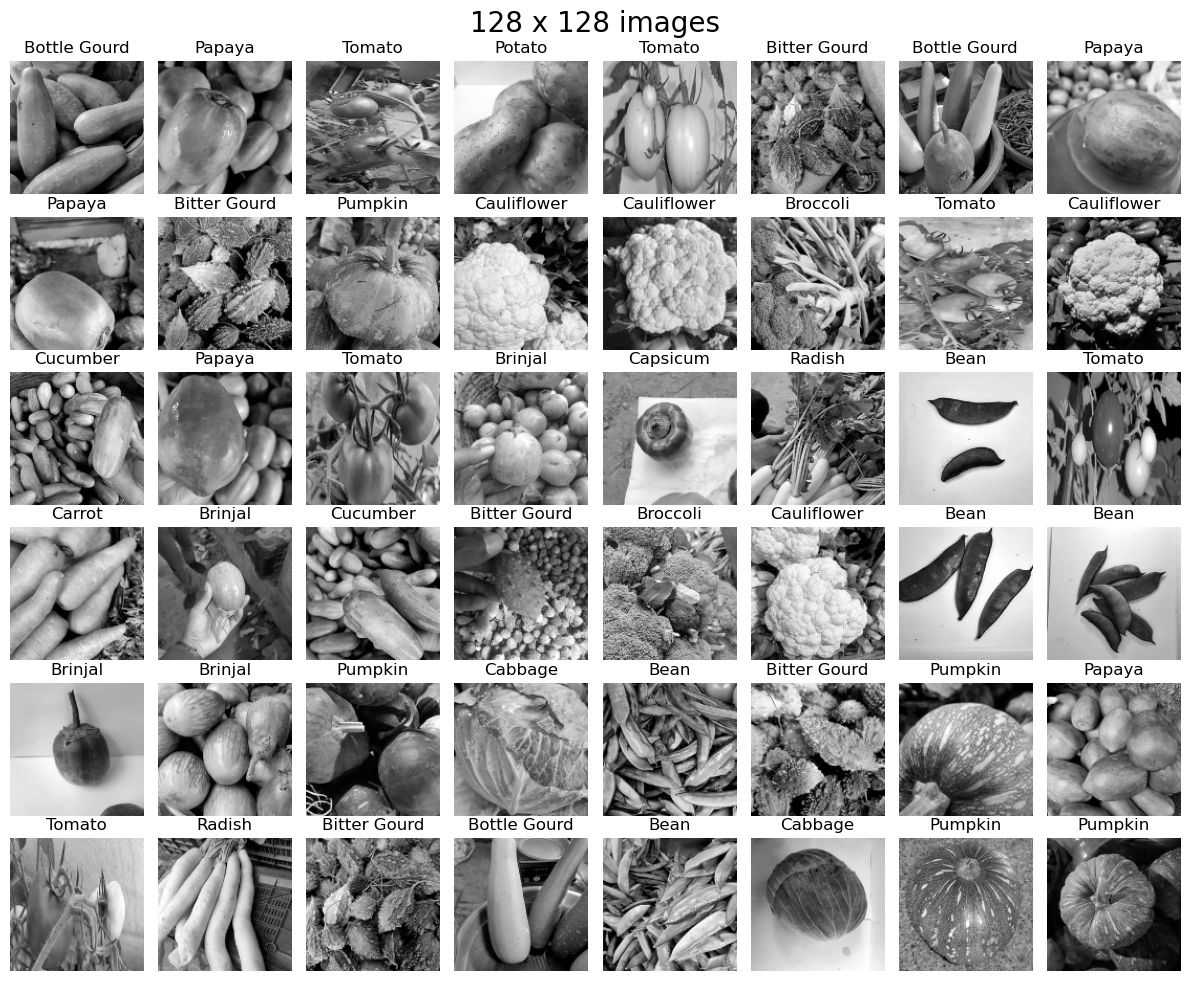

In [50]:
def plot_dataset_huge(amtOfImages, dataset,title,class_labels):
    plt.figure(figsize=(12, 10))
    plt.suptitle(title, fontsize=20)
    for images, labels in dataset.take(1):
        num_images = len(images)  

        row = int(np.sqrt(amtOfImages))
        col = int(np.ceil(amtOfImages / row))
            
        for i in range(min(amtOfImages, num_images)):
            ax = plt.subplot(row, col, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
            plt.title(class_labels[np.argmax(labels[i])])
            plt.axis("off")

    plt.subplots_adjust(wspace=0.1, hspace=0.01)
    plt.tight_layout()
    plt.show()

plot_dataset_huge(48,dataset_train_128,'128 x 128 images',class_labels)

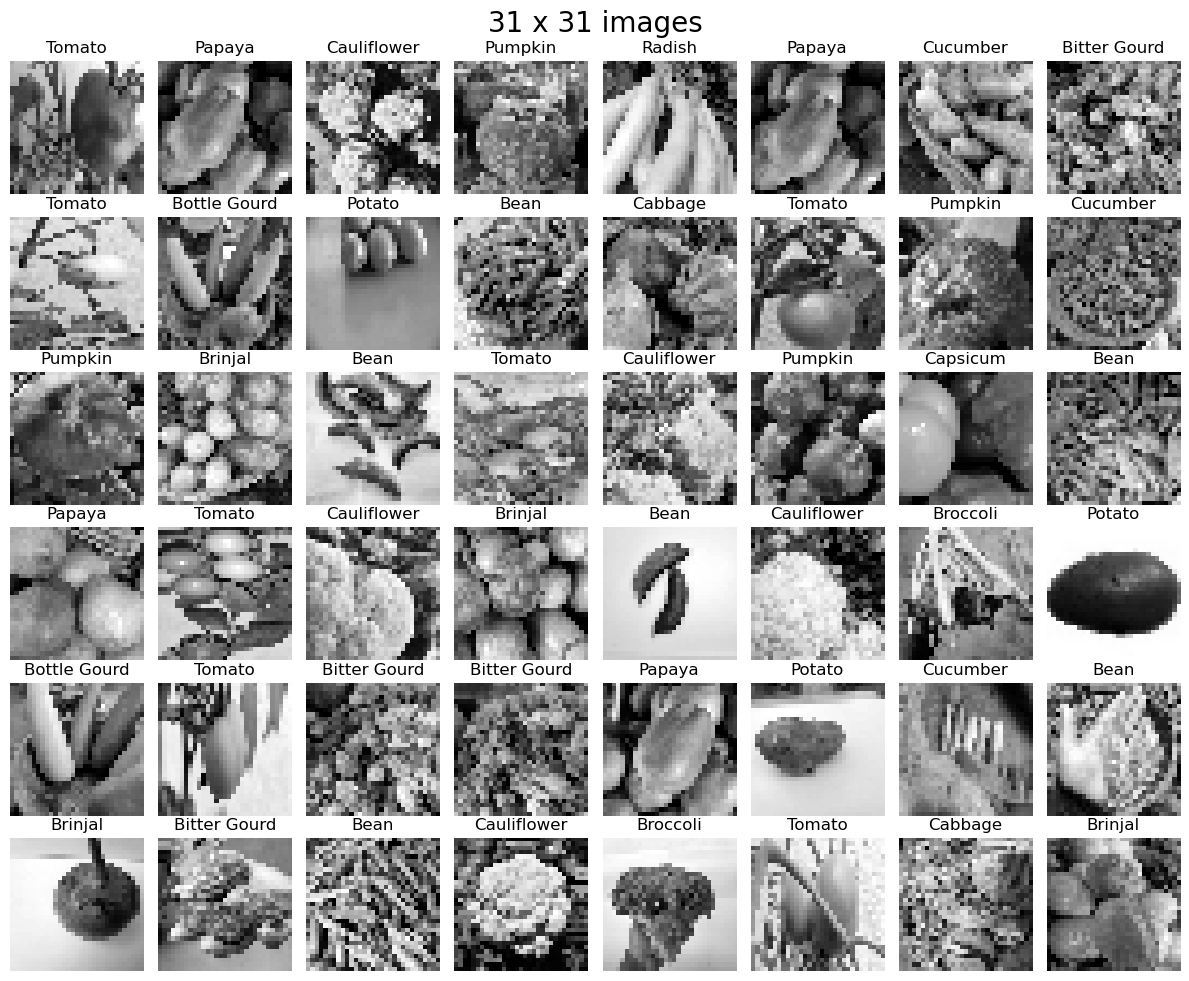

In [51]:
plot_dataset_huge(48,dataset_train_31,'31 x 31 images',class_labels)

Observations:
- Cauliflowers and Potatos are easily differentiable, with potatos usually having a white background and cauliflowers having 

### Class Distribution

In [12]:
class_counts_df = pd.DataFrame(columns=class_labels)

def count_classes(dataset, class_labels):
    class_count = {label: 0 for label in class_labels}
    for _, labels in dataset:
        for label in labels:
            class_name = class_labels[tf.argmax(label)]
            class_count[class_name] += 1
    return class_count

class_counts_df.loc['Validation'] = count_classes(dataset_validation_128, class_labels)
class_counts_df.loc['Training'] = count_classes(dataset_train_128, class_labels)
class_counts_df.loc['Test'] = count_classes(dataset_test_128, class_labels)
class_counts_df.loc['Total Classes'] = class_counts_df.sum()
class_counts_df['Total Datasets'] = class_counts_df.sum(axis=1)

class_counts_df

,Bean,Bitter Gourd,Bottle Gourd,Brinjal,Broccoli,Cabbage,Capsicum,Carrot,Cauliflower,Cucumber,Papaya,Potato,Pumpkin,Radish,Tomato,Total Datasets
Validation,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,3000
Training,780,720,441,868,750,503,351,256,587,812,566,377,814,248,955,9028
Test,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,3000
Total Classes,1180,1120,841,1268,1150,903,751,656,987,1212,966,777,1214,648,1355,15028


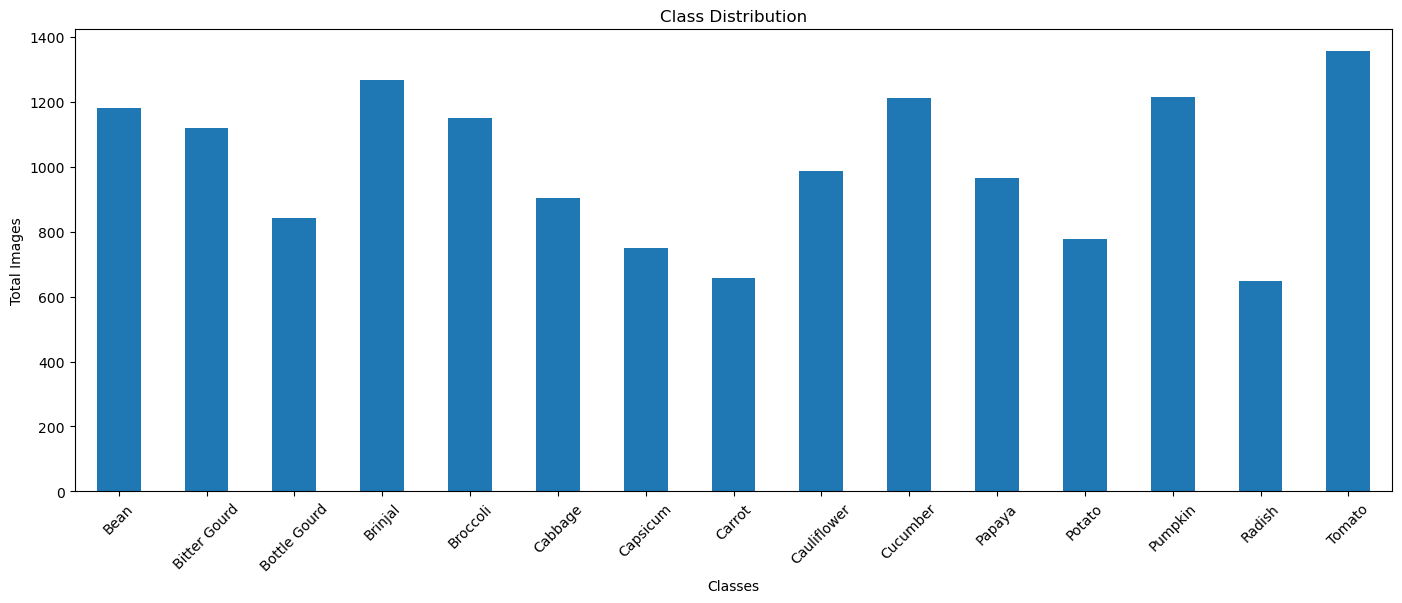

In [13]:
class_counts_df_plot = class_counts_df.drop(['Total Datasets'], axis=1)
class_counts_df_plot = class_counts_df_plot.T
class_counts_df_plot

# Plot the bar graph
class_counts_df_plot['Total Classes'].plot(kind='bar', figsize=(17, 6))
plt.xlabel('Classes')
plt.ylabel('Total Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

We can see that we have an class imbalance for our train dataset. Oh No!! What should we do?
- There are quite alot of solutions for this problem, here are 3 main solutions:
    1. We can augment our data on the minority classes(Bottle_gourd, carrots and radish). However we want to also augment our other images classes to prevent overfitting so this is not a good option.
    2. We can oversample or undersample our minority or majority classes.However oversampling can lead to overfitting without any data augmentation.
    3. We can modify the loss function to assign different weights to each class, such as increasing the loss weigh for our minority class.


We will be assigning different weights for each class for a few reasons:
- It helps preserve our data....
- Prevents overfitting....
- Much simpler than Image oversampling...

In [25]:
class_counts_df_plot['Training'].values

array([780, 720, 441, 868, 750, 503, 351, 256, 587, 812, 566, 377, 814,
       248, 955], dtype=int64)

In [22]:
class_weights = tf.math.reciprocal(tf.constant(
(class_counts_df_plot['Training'].values).astype(np.float32)))

# Normalize the class weights
class_weights = class_weights / tf.reduce_sum(class_weights)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights.numpy())}

print("Class Weights:", class_weights_dict)

tf.Tensor(
[0.04297926 0.04656086 0.07601774 0.03862191 0.04469843 0.06664775
 0.09550946 0.13095243 0.05711043 0.0412855  0.05922937 0.0889226
 0.04118406 0.1351767  0.03510348], shape=(15,), dtype=float32)
Class Weights: {0: 0.042979263, 1: 0.046560865, 2: 0.07601774, 3: 0.038621914, 4: 0.04469843, 5: 0.06664775, 6: 0.09550946, 7: 0.13095243, 8: 0.05711043, 9: 0.041285496, 10: 0.05922937, 11: 0.088922605, 12: 0.041184057, 13: 0.1351767, 14: 0.03510348}


Another important question to ask is. 
- What are our pixel distributions for our datasets? and what is the std and mean of them? 

In [55]:
def compute_statistics(dataset,title):
    pixel_min = float('inf') 
    pixel_max = float('-inf')
    pixel_sum = 0
    pixel_sum_square = 0
    num_pixels = 0

    for images, _ in dataset:
        for image in images:
            # Calculate min and max pixel values
            pixel_min = min(pixel_min, np.min(image))
            pixel_max = max(pixel_max, np.max(image))

            # Update sum and sum of squares for mean and std calculation
            pixel_sum += np.sum(image)
            pixel_sum_square += np.sum(image ** 2)
            num_pixels += np.prod(image.shape)

    # Calculate mean and std
    pixel_mean = pixel_sum / num_pixels
    pixel_std = np.sqrt((pixel_sum_square / num_pixels) - (pixel_mean ** 2))

    print(title)
    print("Min Pixel Value:", pixel_min)
    print("Max Pixel Value:", pixel_max)
    print("Mean Pixel Value:", pixel_mean)
    print("Standard Deviation:", pixel_std)

    return

compute_statistics(dataset_train_31,'Training Images')
compute_statistics(dataset_test_31,'Test Images')
compute_statistics(dataset_validation_31,'Validation Images')

Training Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 114.34127948859215
Standard Deviation: 55.387912533676406
Test Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 114.66371605098855
Standard Deviation: 55.07995207606749
Validation Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 113.78344607803287
Standard Deviation: 55.49623592897191


- Our pixel values range from 0 to 255, which is expected as grayscale images typically have pixel values ranging from 0 (black) to 255 (white). 
- Our average pixel is around 114, which means that our images are not heavily skewed toward either very dark or very bright values.

### Image Averaging
We will be using only the test and validation datasets for averaging as the train set has class imbalance and may result in inaccurate results.

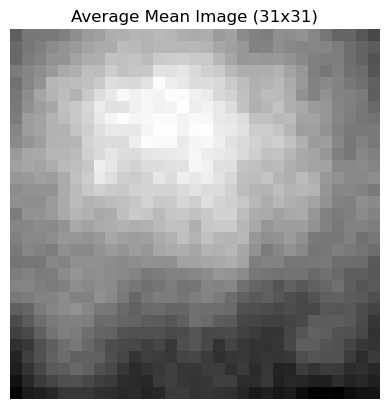

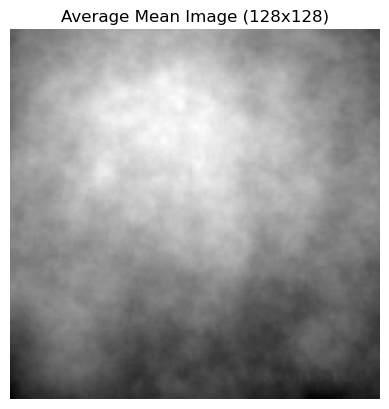

In [61]:
def calculate_mean_image(datasets,image_size,title):
    pixel_sum = np.zeros((image_size[0], image_size[1]), dtype=np.float64)
    num_images = 0
    mean_images = np.zeros((image_size[0], image_size[1]), dtype=np.float64)
    for dataset in datasets:
        for images, _ in dataset:
            for image in images:
                pixel_sum += np.squeeze(image, axis=-1)
                num_images += 1

        # Calculate the mean image
        mean_image = pixel_sum / num_images
        mean_images = mean_images + mean_image
    
    mean_images = mean_images / len(datasets)

    plt.imshow(mean_images, cmap='gray')
    plt.title(title)
    plt.axis("off")
    plt.show()
    return

image_size_31 = (31, 31)
image_size_128 = (128, 128)

calculate_mean_image([dataset_test_31,dataset_validation_31],image_size_31,'Average Mean Image (31x31)')
calculate_mean_image([dataset_test_128,dataset_validation_128],image_size_128,'Average Mean Image (128x128)')

The mean image for all the images combined looks like a fog, we cant really determine any of or classes from this average image.

In [65]:
def calculate_mean_images_by_class(dataset, image_size):
    # Create a dictionary to store the mean images for each class
    class_mean_images = {}
    class_counts = {}

    for images, labels in dataset:
        for image, label in zip(images, labels):
            # Get the label of the image

            # Initialize the class_mean_image and class_counts if it doesn't exist
            # if label not in class_mean_images:
            #     class_mean_images[label] = np.zeros((image_size[0], image_size[1]), dtype=np.float64)
            #     class_counts[label] = 0

            # Update the mean image and count for the class
            class_mean_images[label] += np.squeeze(image, axis=-1)
            class_counts[label] += 1

    # Calculate the mean image for each class
    for label in class_mean_images:
        class_mean_images[label] /= class_counts[label]

    return class_mean_images

# Example usage:
# Assuming 'dataset' is a dataset with images and labels
class_mean_images = calculate_mean_images_by_class(dataset_test_31, image_size_31)

TypeError: Tensor is unhashable. Instead, use tensor.ref() as the key.

## Data Preprocessing

### Encoding (maybe)

### Normalizing

## Data Augementation


## Models
- Base
- custom model


## Hyperparemeter Tuning

## Final Model